# Potential Energy Surfaces

In [90]:
import os

import matplotlib.pyplot as plt
import numpy as np
import scipy
import json
import pandas as pd

import sys
sys.path.append("../src/")

import hessian
import system
import chl_xtb


In [47]:
os.environ["QCORE_PATH"] = "~/qcore/cmake-build-release/bin/qcore"

In [48]:
modes = hessian.get_modes("../data/hessians/monomer_normal_modes.molden", 414, 140)
wavenumbers = hessian.get_wavenumbers("../data/hessians/monomer_normal_modes.molden")
frequencies = hessian.wavenumber_to_frequency(wavenumbers)
modes = modes.transpose(2, 0, 1)

In [49]:
symbols, xyz = system.read_xyz("../data/hessians/opt_bchla.xyz")

$ q_{i} = \sqrt{\frac{m \omega_{i}}{\hbar}} \hat{x} $

$ [q_{i}] = \sqrt{\frac{kg 2 \pi s^{-1}}{\frac{J s}{2 \pi }}} m $

$ [q_{i}] = \sqrt{\frac{kg 2 \pi s^{-1}}{\frac{kg m^2 s^{-2} s}{2 \pi }}} m $

$ [q_{i}] = \sqrt{\frac{2 \pi}{\frac{m^2}{2 \pi }}} m $

$ [q_{i}] = \sqrt{\frac{4 \pi^2}{m^2}}m $

$ [q_{i}] = \frac{2 \pi}{m}m $

$ [q_{i}] = 2 \pi $

In [50]:
def move_along_mode(origin, mode, freq, disp):
    #units
    hbar = scipy.constants.hbar
    au_to_kg = scipy.constants.physical_constants["atomic mass constant"][0] 
    
    
    #move along mode
    mode = mode * 0.529177 # bohr to angstrom
    norm = np.sum(np.linalg.norm(mode, axis=1))
    res = origin + disp * mode/norm
    
    
    #assert amount displacement is correct
    diff = origin - res
    total_diff = np.sum(np.linalg.norm(diff, axis=1))
    assert(abs(total_diff - abs(disp)) < 1e-6)
    
    
    #calculate q
    omega = freq * 1e15 * 2 * np.pi # fs^-1 * s^-1/fs^-1 * 2\pi
    
    masses = [system.masses()[symbols[i]] * au_to_kg for i in range(len(mode))]
    mass_weighted = np.array([diff[i] * 1e-10 * np.sqrt(masses[i]) for i in range(len(mode))]) #1e-10 for A to m conversion
    mass_weighted_disp = np.sign(disp) * np.linalg.norm(mass_weighted, axis=1)
    
    q = np.sum(np.sqrt(omega/hbar) * mass_weighted_disp)
    
    return res, q


move_along_mode(xyz, modes[5], frequencies[5], 1)

def write_xyz(symbols, xyz):
    coord_list = ([f"['{s}', {c[0]}, {c[1]}, {c[2]}]" for s, c in zip(symbols, xyz)])
    
    return f"[{', '.join(coord_list)}]"


CO stretch, 1725.22 cm^-1, HRF: 0.012


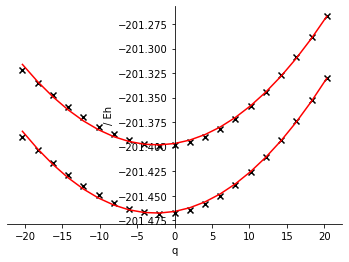

In [51]:
def run_displacement(mode, freq, symbols, origin, disp):
    moved, q = move_along_mode(origin, mode, freq, disp)
    qcore_str = f"\"res := xtb(model='chlorophyll' structure(xyz = {write_xyz(symbols, moved)}))\""

    res = chl_xtb.run_qcore(qcore_str)
    
    ground_energy = res["res"]["energy"]
    transition_energy = res["res"]["excitation_1_energy"]
    excited_energy = ground_energy + transition_energy
    
    return ground_energy, transition_energy, excited_energy, q


fig, ax = plt.subplots()
ax.spines['left'].set_position('center')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

disps = np.linspace(-1, 1, 21)

for i in [336]:
    print(f"CO stretch, {wavenumbers[i]:4.2f} cm^-1", end=', ')
    energies = [run_displacement(modes[i], frequencies[i], symbols, xyz, d) for d in disps]
    
    qs = [e[3] for e in energies]
    ground = [e[0] for e in energies]
    excited = [e[2] for e in energies]

    g_coeffs = np.polyfit(qs, ground, 2)
    e_coeffs = np.polyfit(qs, excited, 2)

    g_poly = np.poly1d(g_coeffs)
    e_poly = np.poly1d(e_coeffs)

    g_pred = g_poly(qs)
    e_pred = e_poly(qs)
    
    g_crit = g_poly.deriv().r
    e_crit = e_poly.deriv().r

    hrf = (e_crit[0] - g_crit[0])**2/2
    print(f"HRF: {hrf:3.3f}")

    plt.scatter(qs, ground, color='black', marker='x')
    plt.plot(qs, g_pred, color='red')

    plt.scatter(qs, excited, color='black', marker='x')
    plt.plot(qs, e_pred, color='red')
    
    plt.xlabel("q")
    plt.ylabel("/ Eh")

In [5]:
with open("../data/hessians/huang_rhys.json") as hr_json:
    res = json.load(hr_json)

In [93]:
res_pd = pd.DataFrame(res).T

dict_keys(['displacements', 'ground_energies', 'transition_energies', 'excited_energies', 'q_coords', 'g_min', 'e_min', 'hrf', 'wavenumber', 'frequency'])


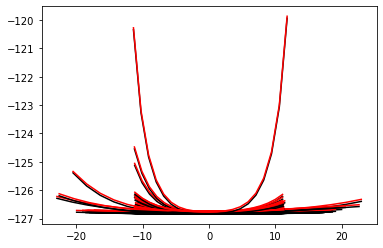

In [35]:
fig, ax = plt.subplots()

print(res["mode_3"].keys())

for mode in res.keys():
    ax.plot(res[mode]["q_coords"], res[mode]["ground_energies"], color='black')
    ax.plot(res[mode]["q_coords"], res[mode]["excited_energies"], color='red')

In [104]:
#pd.set_option('display.max_rows', 10)
res_pd = res_pd.sort_values("hrf", ascending=False)

for index, row in res_pd.iterrows():
    print(np.min(row["q_coords"]) <  row["g_min"] < np.max(row["q_coords"]))

False
True
True
True
True
False
True
False
True
True
False
True
False
True
True
True
False
True
False
False
False
True
True
True
True
True
False
True
True
True
True
True
True
False
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
True
True
True
True
True
True
True
True
False
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
